# 2장. 파이썬에서의 기술적 분석
- 기술 분석(TA)의 기본 사항
  - 과거 시장 데이터(특히 가격 & 거래량)을 이용해 자산 가격의 미래 방향을 결정하고 투자 기회를 식별한다.

- 1. 촛대 차트를 사용해 주가 시각화
- 2. TA에 사용된 선택 지표들을 계산하는 방법
- 3. 파이썬 라이브러리를 사용해 TA 지표를 기반으로 구축한 거래 전략을 테스트하는 것을 보여줄 것.
- 4. 대화형 대시보드를 만드는 법

## 1. 촛대 차트 만들기
- 시가, 고가, 저가, 종가를 결합
- 조정 종가의 단순 선 그래프보다 많은 것을 포함한다.

In [2]:
import pandas as pd
import yfinance as yf

ModuleNotFoundError: No module named 'yfinance'

In [14]:
df_twtr = yf.download(
    'TWTR',
    start='2018-01-01',
    end='2018-12-31',
    progress=False,
    auto_adjust=True
)

In [15]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode()

qf = cf.QuantFig(df_twtr, title="Twitter's Stock Price", legend="top", name='TWTR')

qf.add_volume() # 이 메소드는 알아서 Volume column을 인지해서 사용되나봄
qf.add_sma(periods=20, column='Close', color='red')
qf.add_ema(periods=20, color='green')

qf.iplot()

- 위의 그림에서 SMA(단순 이동 평균)과 EMA(지수 이동 평균)이 사용되었음. 지수 이동 평균이 단순 이동 평균보다 가격 변동에 빠르게 적응한다.
- add_sma, add_ema 메서드를 사용해서 2개의 이동평균 선을 추가했으며, 20일 기간(periods 인자)를 고려하기로 함.
- 지수는 최근 가격에 더 많은 가중치를 부여한다. 즉 추세 변화에 더 빠르게 반응

In [16]:
# add_volume() 메서드가 없으면 어떻게 그려지는지 보고 싶어서 해 봤습니다.
qf2 = cf.QuantFig(df_twtr, title="Twitter's Stock Price", legend="top", name='TWTR')
qf2.iplot()

## 2. 단순 이동 평균을 기반으로 전략 백테스팅
- 백테스팅 : 거래 전략의 성능을 과거 데이터에 적용해서 평가해 보기
- 백테스트로 사용 가능한 프레임워크인 backtrader
  - 많은 기술 지표 제공
  - 지표 구축 및 적용이 쉽다.
  - 다양한 데이터 소스가 제공됨
  - 서로 다른 형태의 주문, 슬리피지, 커미션, 롱/숏 등 여러 가지 시뮬레이션
  - 코드 한 줄로 도면을 그려서 결과 파악 가능
  

- SMA에 기반한 기본 전략
  - 종가가 20일 SMA보다 높아지면 한 주를 산다.
  - 종가가 20일 SMA보다 낮아지고 주식을 보유한 상태면 매도
  - 주어진 시간에 오직 한 주만 허용한다.

- bt.Signal(신호) 를 이용한 거래 전략 / bt.Strategy(전체 전략 정의) 이용한 거래 전략.
- bt.Strategy가 더 많은 로그 기록을 생성하고, 더 쉽게 디버그 할 수 있다.

In [17]:
from datetime import datetime
import backtrader as bt

In [18]:
# 신호
class SmaSignal(bt.Signal):
    params = (('period', 20), )
    def __init__(self):
        self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)

In [19]:
data = bt.feeds.YahooFinanceData(
    dataname='AAPL',
    fromdate=datetime(2018, 1, 1),
    todate=datetime(2018, 12, 31)
)

In [20]:
cerebro = bt.Cerebro(stdstats=False)

cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [21]:
print(f'Starting Portfolio Value : {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value : {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value : 1000.00
Final Portfolio Value : 1002.84


<IPython.core.display.Javascript object>

[[<Figure size 2400x1350 with 3 Axes>]]

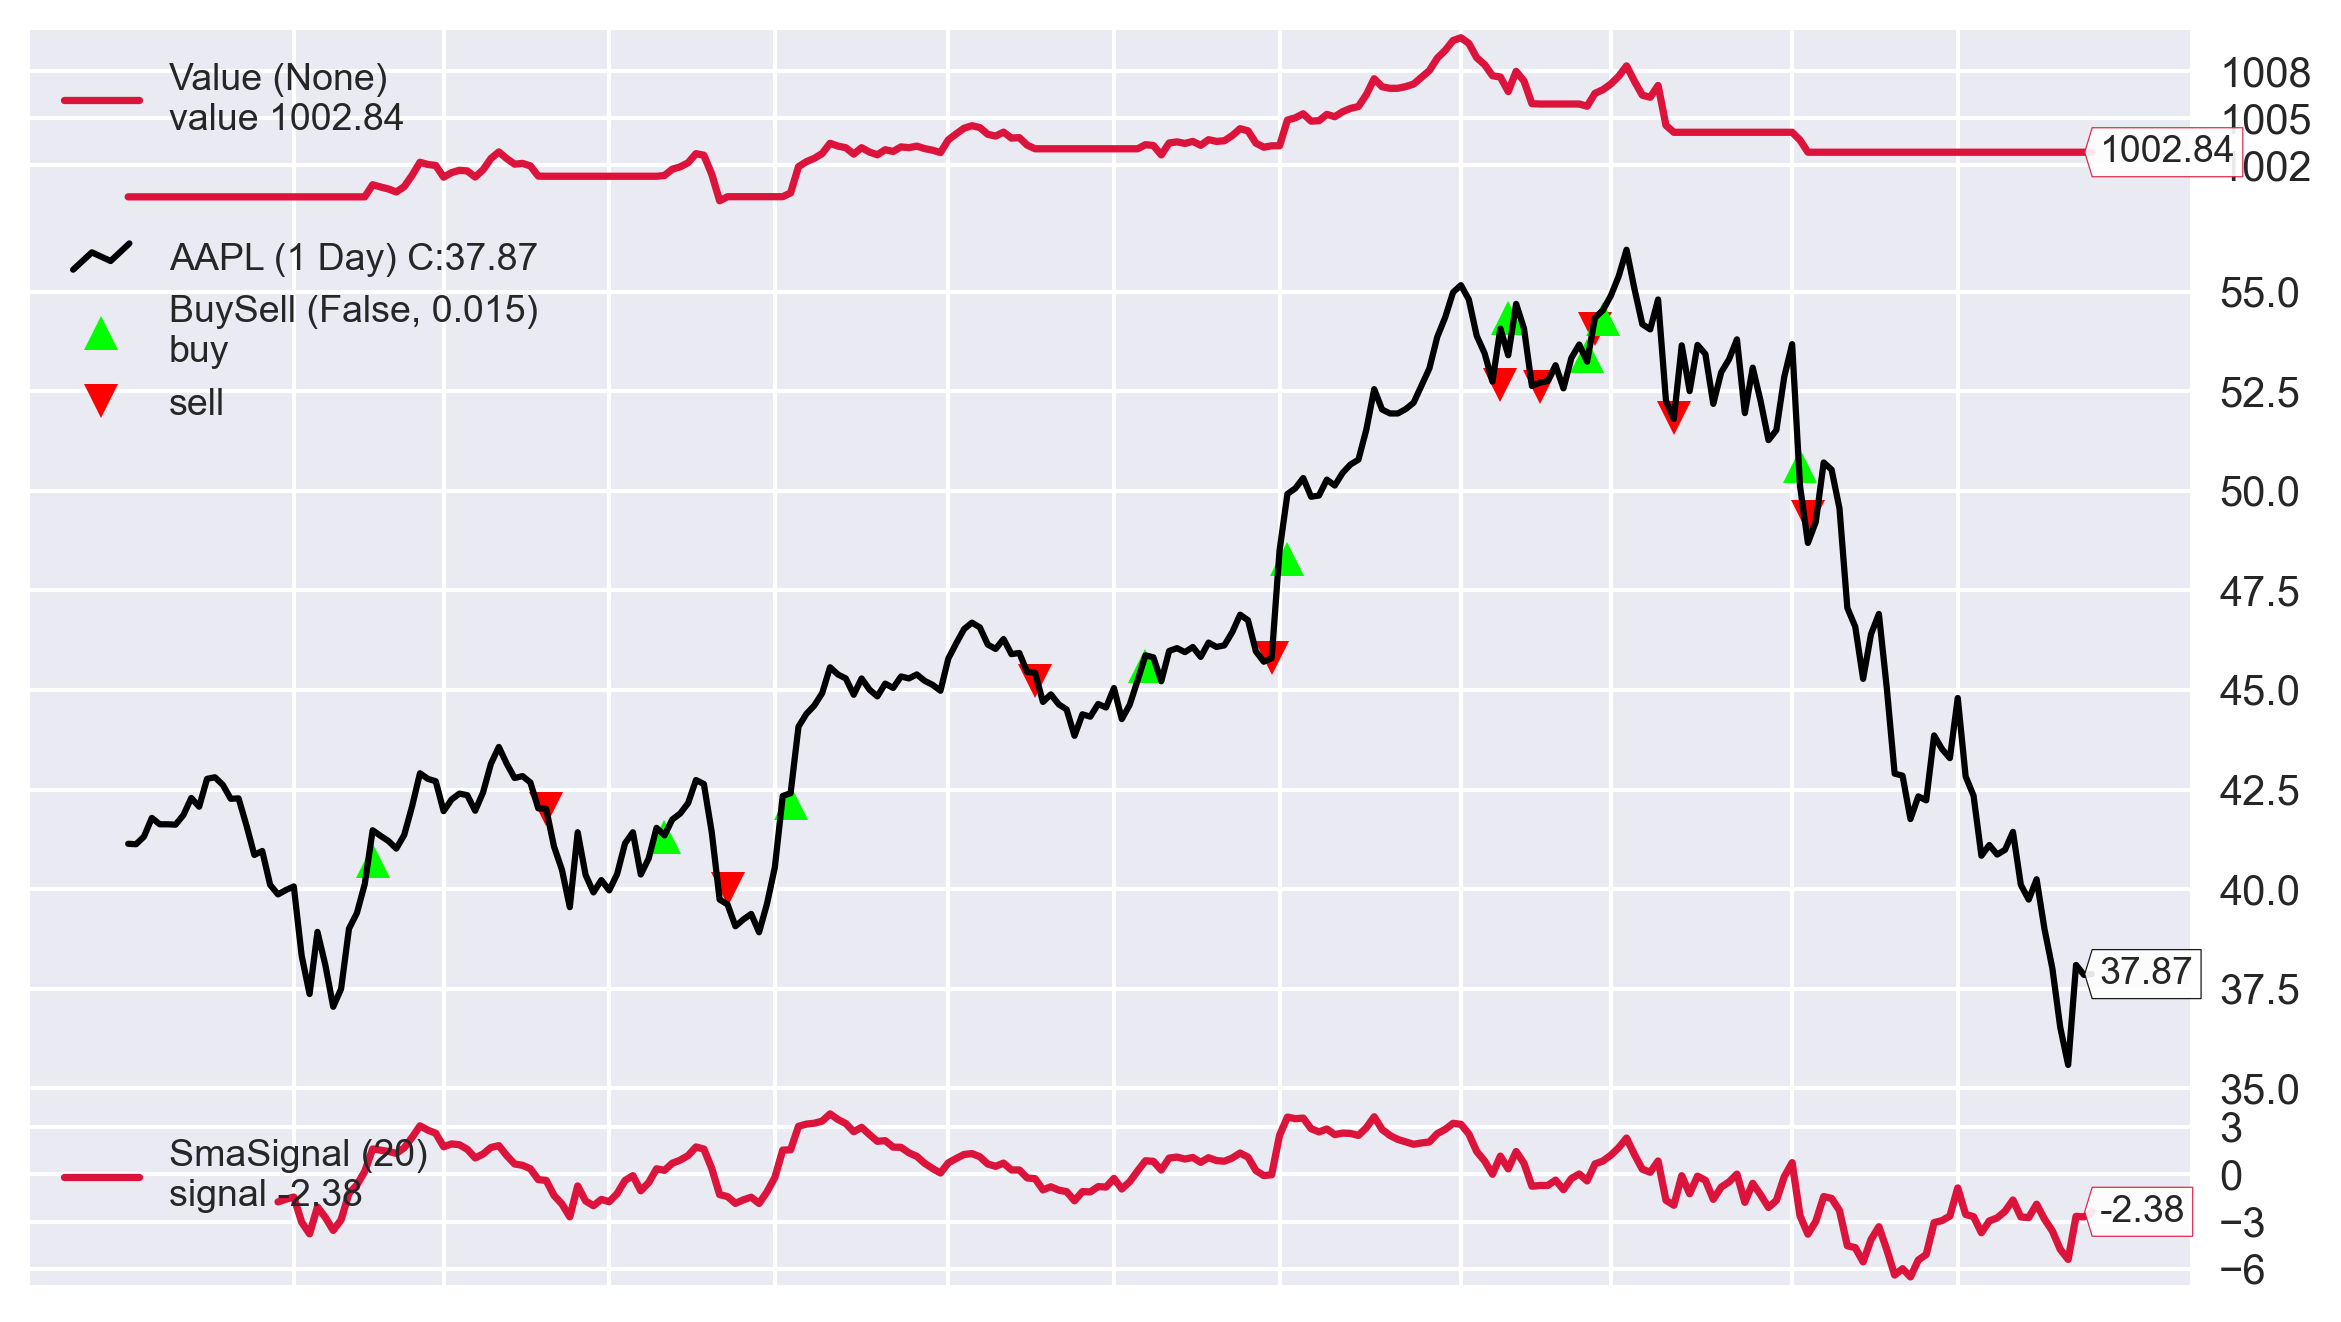

In [22]:
cerebro.plot(iplot=True, volume=False)

In [23]:
class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()

In [24]:
cerebro = bt.Cerebro(stdstats = False)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [25]:
# 볼린저 밴드를 이용한 전략
import backtrader as bt
import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
              ('devfactor', 2.0),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add Bollinger Bands indicator and track the buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0], 
                                            period=self.p.period, 
                                            devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], 
                                           self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0], 
                                            self.b_band.lines.top)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(
                    f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.sell_signal < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [27]:
data = bt.feeds.YahooFinanceData(
    dataname='MSFT',
    fromdate=datetime.datetime(2018, 1, 1),
    todate=datetime.datetime(2018, 12, 31)
)

In [28]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

cerebro.addstrategy(BBand_Strategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')

In [29]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2018-02-12, BUY CREATED --- Size: 118, Cash: 10000.00, Open: 84.18, Close: 84.55
2018-02-12, BUY EXECUTED --- Price: 84.18, Cost: 9933.24, Commission: 9.93
2018-04-19, SELL CREATED --- Size: 118
2018-04-19, SELL EXECUTED --- Price: 91.91, Cost: 9933.24, Commission: 10.85
2018-04-19, OPERATION RESULT --- Gross: 912.14, Net: 891.36
2018-06-29, BUY CREATED --- Size: 115, Cash: 10891.36, Open: 94.69, Close: 94.39
2018-06-29, Order Failed
2018-10-15, BUY CREATED --- Size: 104, Cash: 10891.36, Open: 104.65, Close: 103.39
2018-10-15, Order Failed
2018-10-26, BUY CREATED --- Size: 107, Cash: 10891.36, Open: 101.55, Close: 102.77
2018-10-26, BUY EXECUTED --- Price: 101.55, Cost: 10865.85, Commission: 10.87
Final Portfolio Value: 10380.81


<IPython.core.display.Javascript object>

[[<Figure size 2400x1350 with 4 Axes>]]

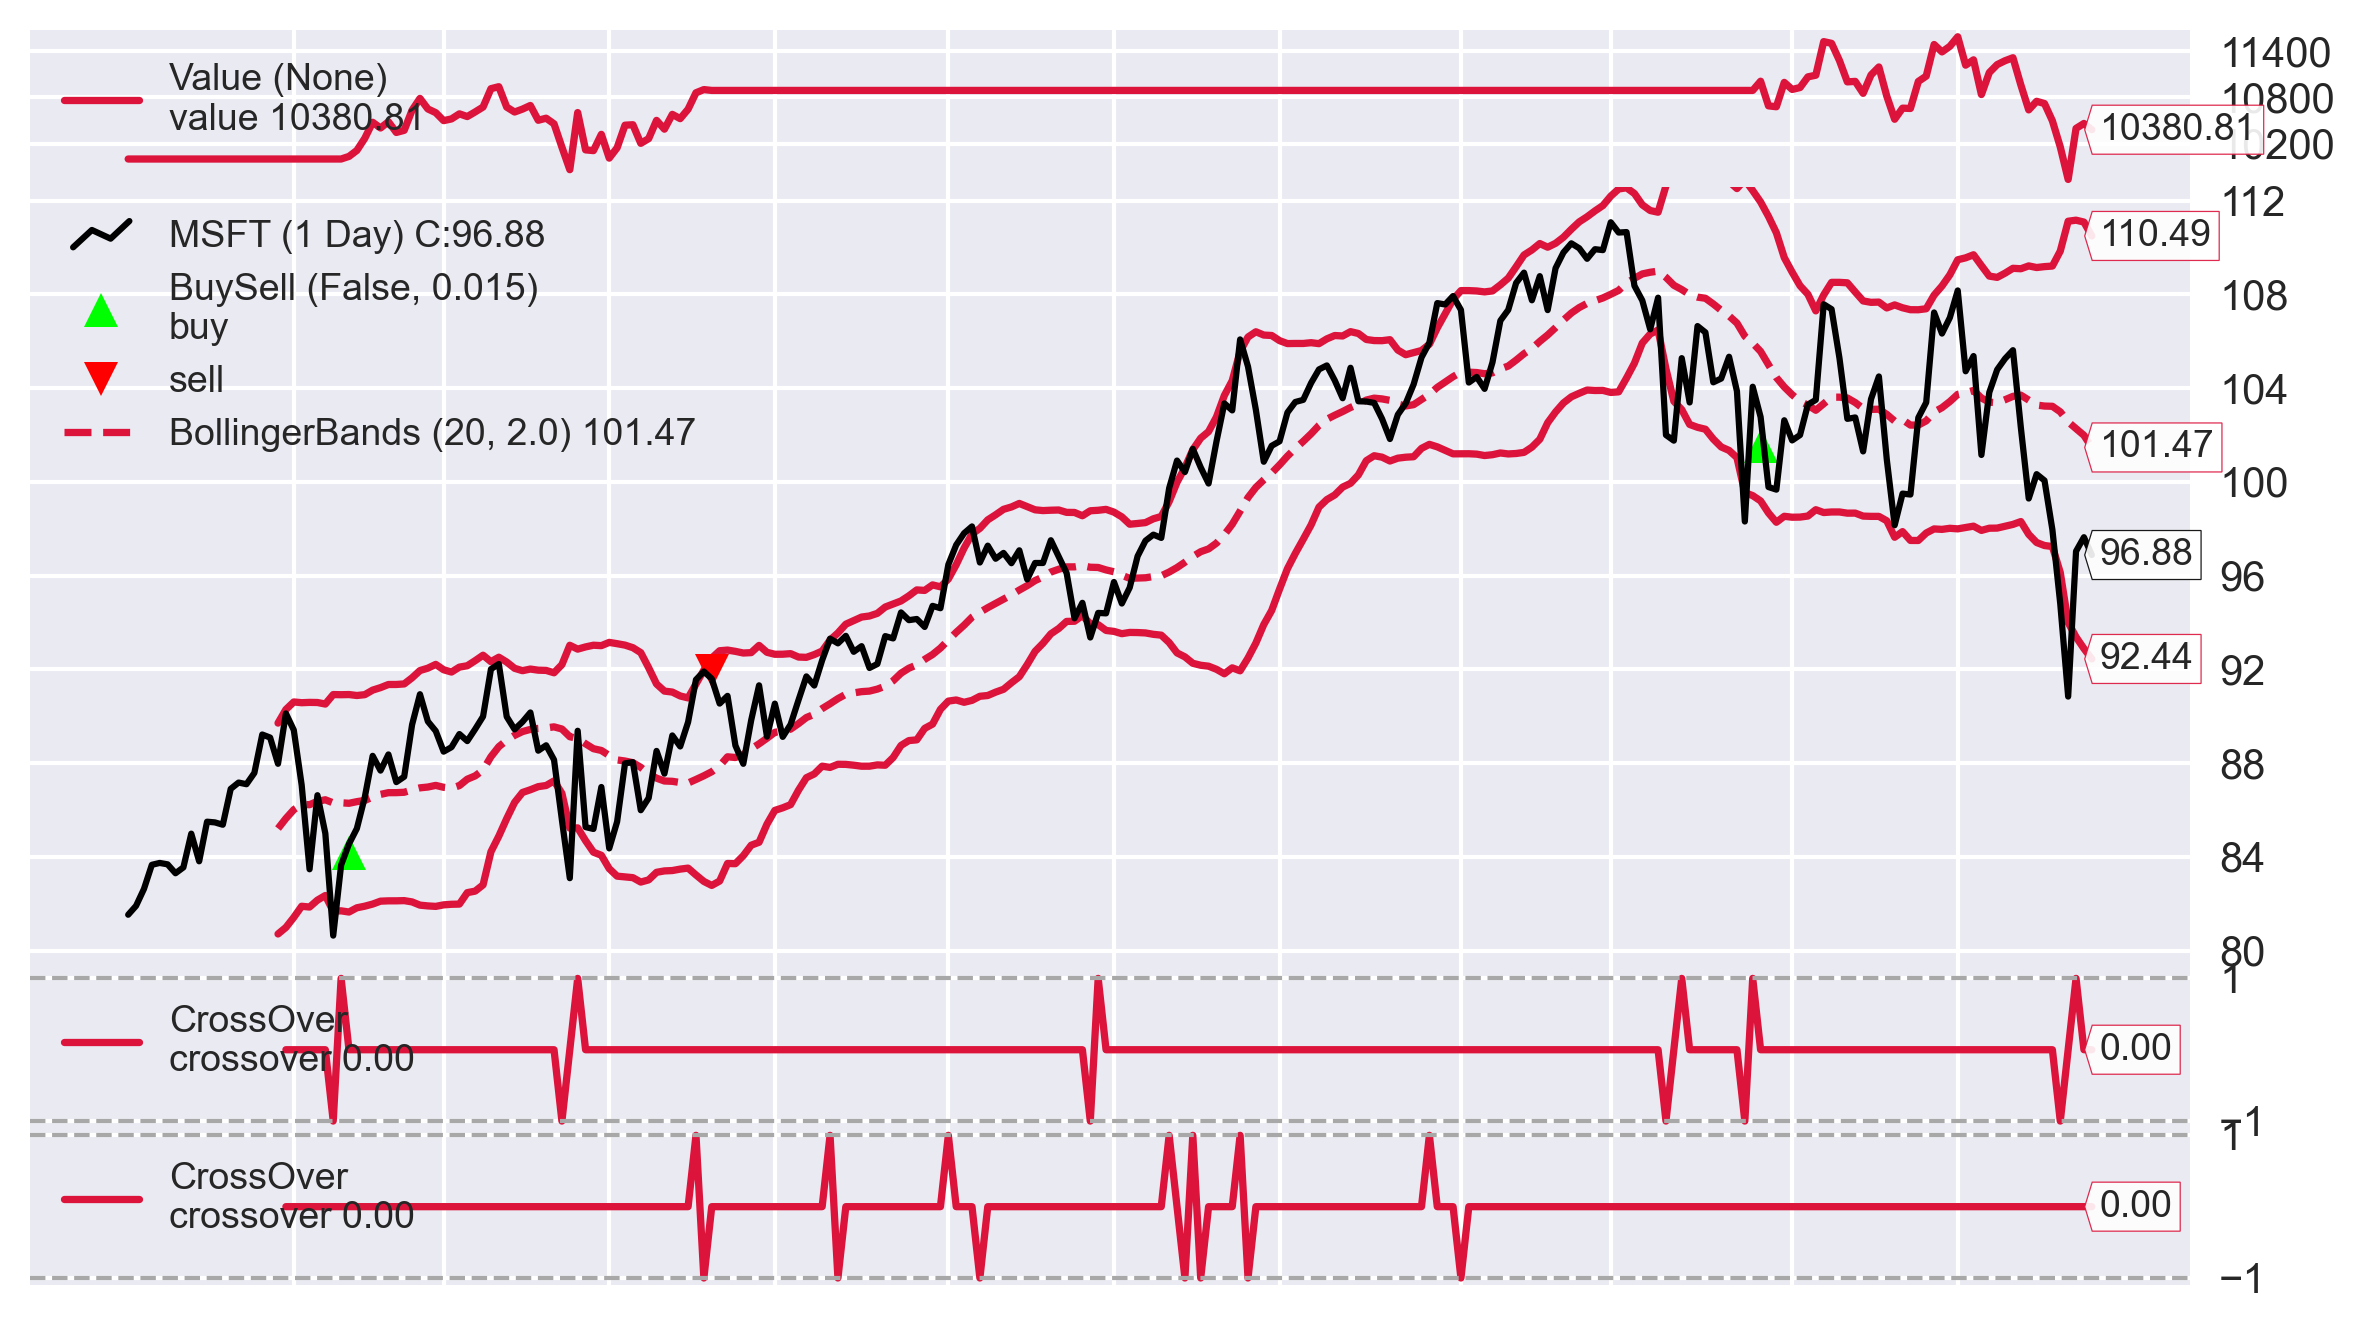

In [30]:
cerebro.plot(iplot=True, volume=False)

In [31]:
print(backtest_result[0].analyzers.returns.get_analysis())

OrderedDict([('rtot', 0.03737338577890115), ('ravg', 0.0001494935431156046), ('rnorm', 0.03839097208315058), ('rnorm100', 3.839097208315058)])


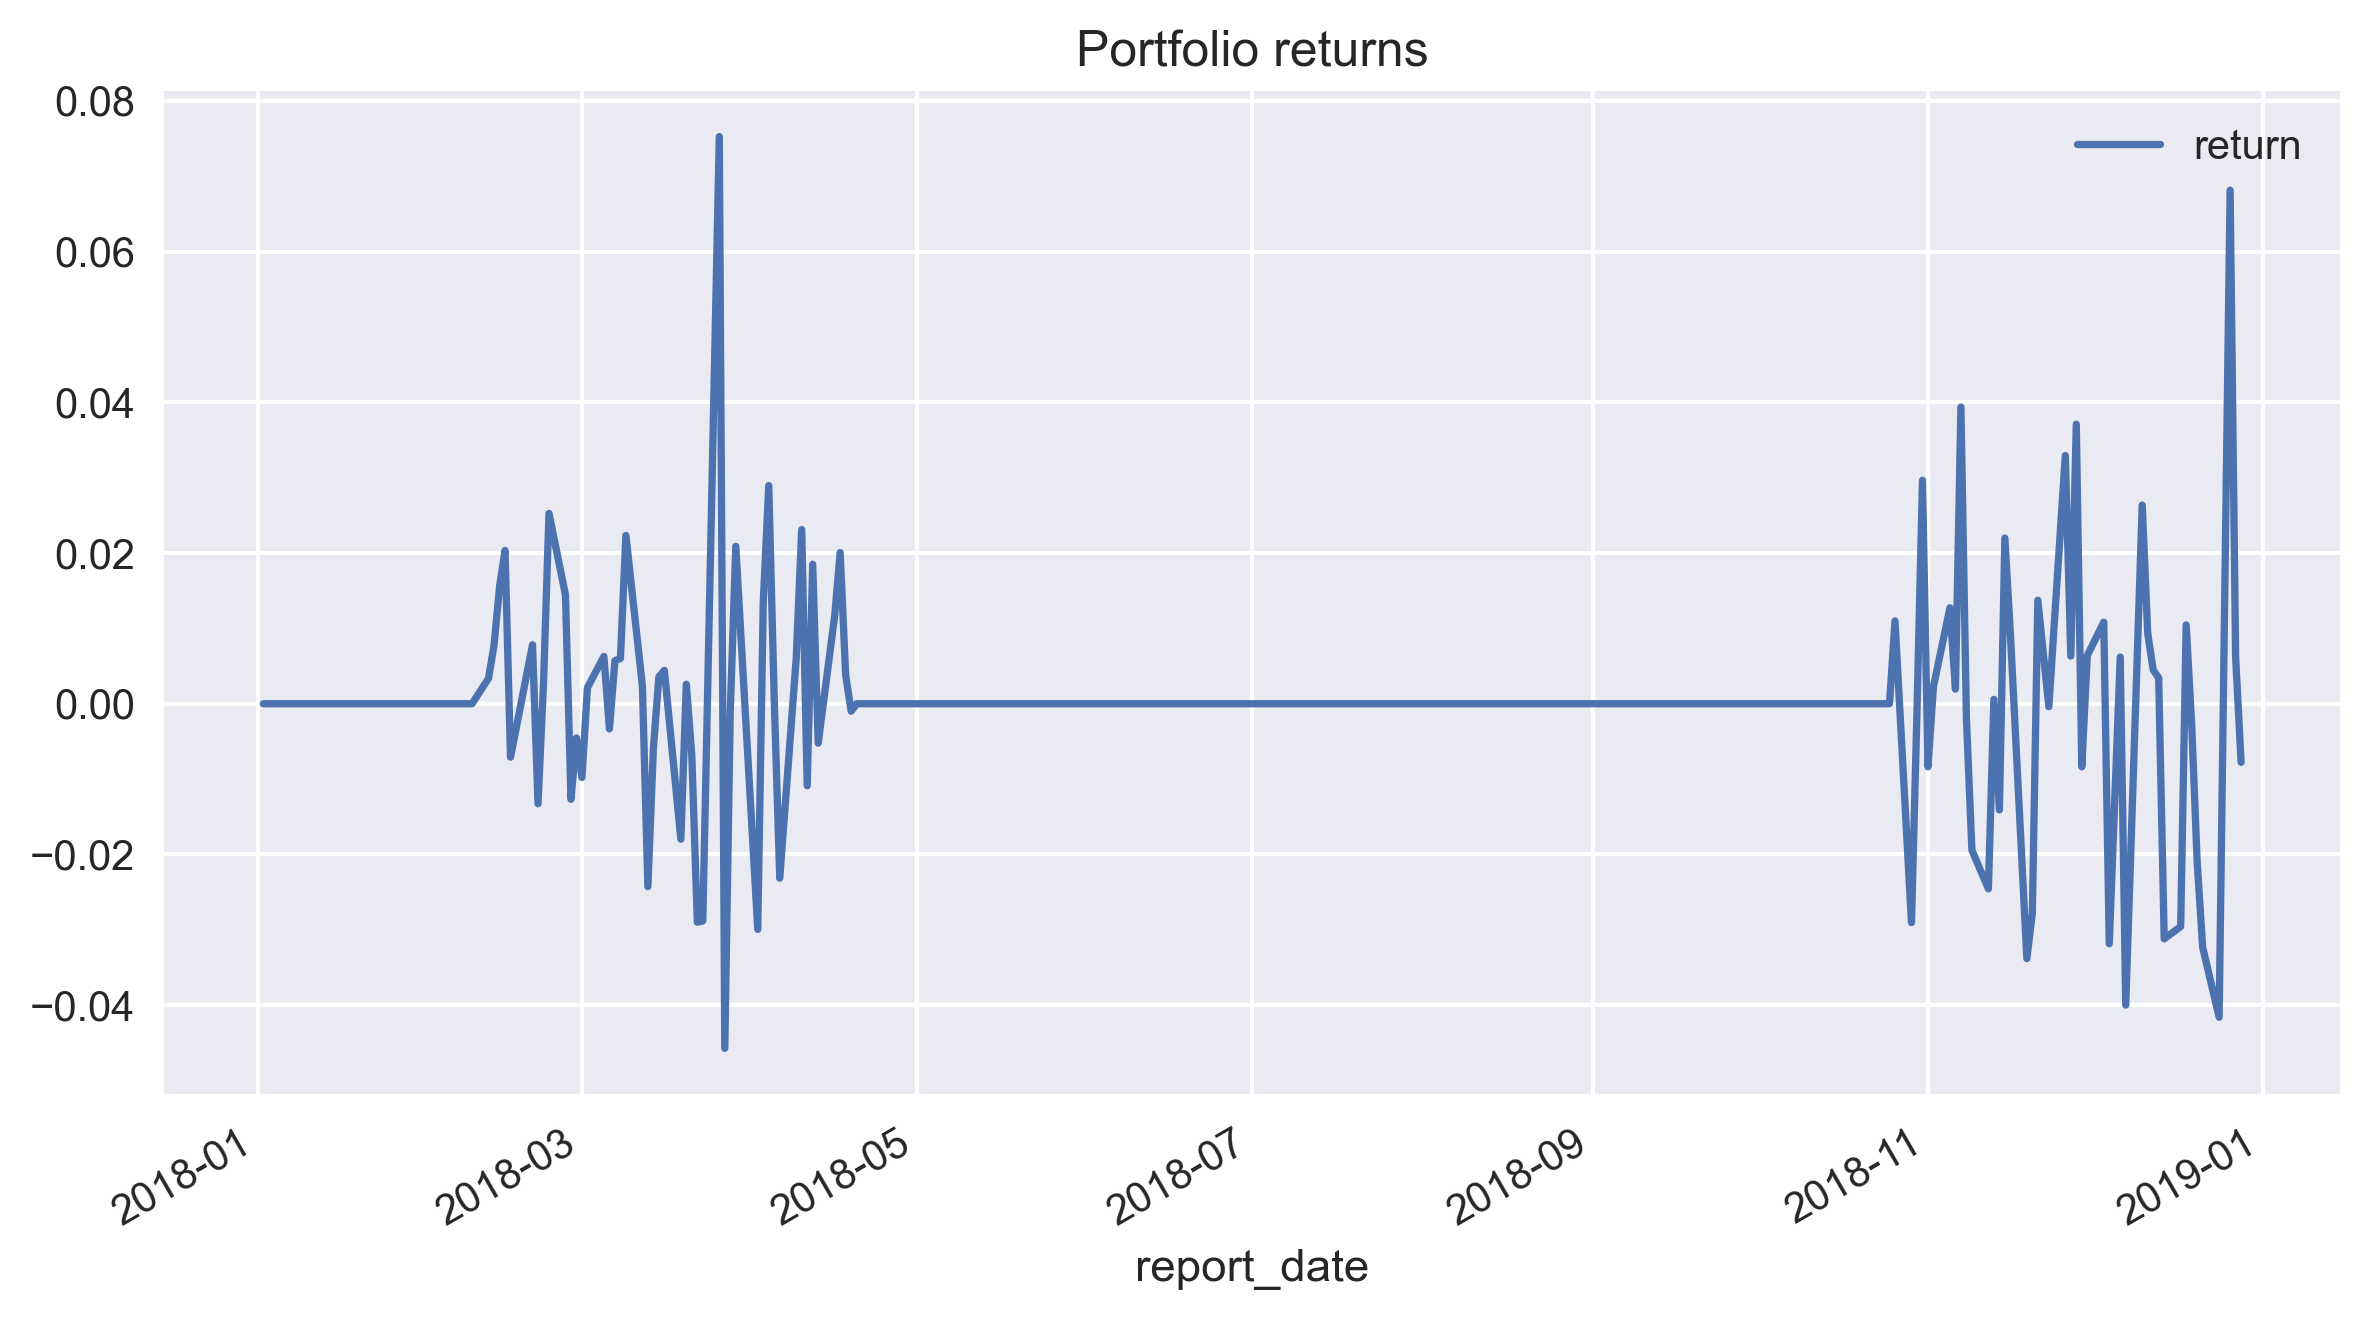

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), 
                          columns = ['report_date', 'return']) \
               .set_index('report_date')
returns_df.plot(title='Portfolio returns')

plt.tight_layout()
# plt.savefig('images/ch2_im9.png')
plt.show()

In [2]:
# RSI 계산을 통한 롱/숏 전략 테스트
from datetime import datetime
import backtrader as bt

# create a Stratey
class RsiSignalStrategy(bt.SignalStrategy):
    params = dict(rsi_periods=14, rsi_upper=70, 
                  rsi_lower=30, rsi_mid=50)

    def __init__(self):
        
        # add RSI indicator
        rsi = bt.indicators.RSI(period=self.p.rsi_periods,
                                upperband=self.p.rsi_upper,
                                lowerband=self.p.rsi_lower)

        # add RSI from TA-lib just for reference 
        # bt.talib.RSI(self.data, plotname='TA_RSI')
        # bt.indicators.RSI(self.data)
    
        # long condition (with exit)
        rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower, plot=False)
        self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
        self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi > self.p.rsi_mid))

        # short condition (with exit)
        rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper, plot=False)
        self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
        self.signal_add(bt.SIGNAL_SHORTEXIT, rsi < self.p.rsi_mid)

In [3]:
data = bt.feeds.YahooFinanceData(dataname='FB', 
                                 fromdate=datetime(2018, 1, 1),
                                 todate=datetime(2018, 12, 31))

In [4]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.addstrategy(RsiSignalStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

cerebro.run()

In [5]:
cerebro.plot(iplot=True, volume=False)

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 3 Axes>]]